In [156]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
from collections import defaultdict
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
import simplejson
import urllib
from configobj import ConfigObj

In [108]:
# here we access the webpage and download the content using requests
movie_list=requests.get("http://www.the-numbers.com/movie/budgets/all")

In [109]:
soup = BeautifulSoup(movie_list.text, "html.parser")
datarows = soup.find_all("td", attrs={"class": "data"})
titlerows = soup.find_all("b")[1:]
titles = [row.get_text() for row in titlerows]
titles = titles[:len(titles)-3]

moviedict = {}
for i, title in enumerate(titles):
    vals = datarows[i*4:(i*4)+4]
    newvals = []
    for val in vals:
        exp = r'((?<=\d),(?=\d))|(\$(?=\d))'
        newvals.append(re.sub(exp,r'',val.get_text()))
    moviedict[title] = [int(val) for val in newvals]
    
movieframe = pd.DataFrame.from_dict(moviedict, orient = 'index')
movieframe.columns = ['budget_rank','budget','domestic_gross','worldwide_gross']
movieframe.sort_values('budget_rank', inplace = True)
movieframe = movieframe[movieframe.domestic_gross > 0]
movieframe['dom_profits'] = map(lambda dom, budget: dom - budget, movieframe['domestic_gross'], movieframe['budget'])
movieframe['total_profits'] = map(lambda world, budget: world - budget, movieframe['worldwide_gross'], movieframe['budget'])
movieframe.head()


,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits
Avatar,1,425000000,760507625,2783918982,335507625,2358918982
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425
Spectre,3,300000000,178416219,751916219,-121583781,451916219
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090


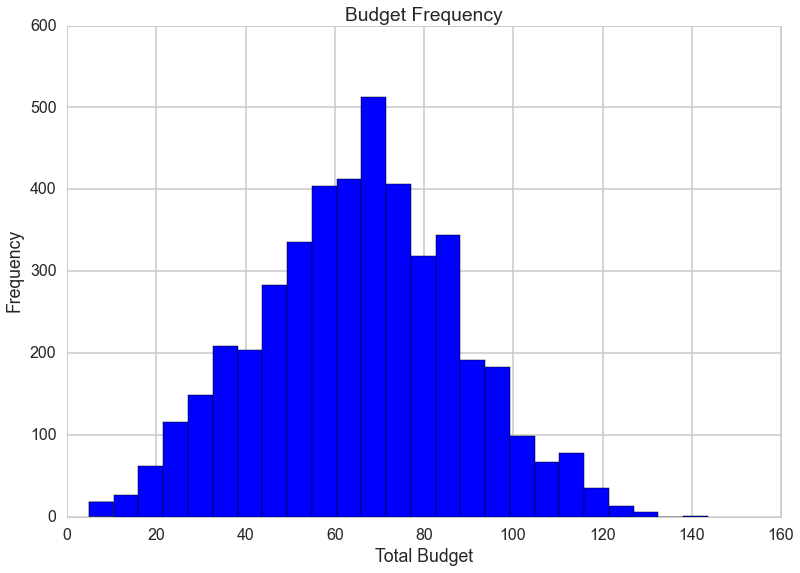

In [110]:
movieframe["budget_quart"] = movieframe['budget'].apply(lambda x : x ** .25)

plt.hist(movieframe["budget_quart"], bins = 25, color = "b")
plt.xlabel("Total Budget")
plt.ylabel("Frequency")
plt.title("Budget Frequency")

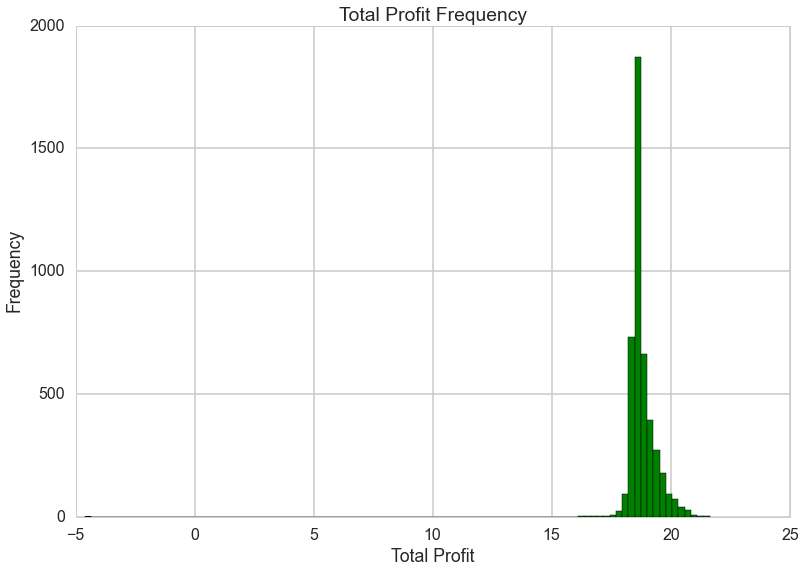

In [122]:
a = np.abs(movieframe["total_profits"].min()) + .01
movieframe["profit_transform"] = movieframe['total_profits'].apply(lambda x : np.log(x + a))

plt.hist(movieframe["profit_transform"], bins = 100, color = "g")
plt.xlabel("Total Profit")
plt.ylabel("Frequency")
plt.title("Total Profit Frequency")

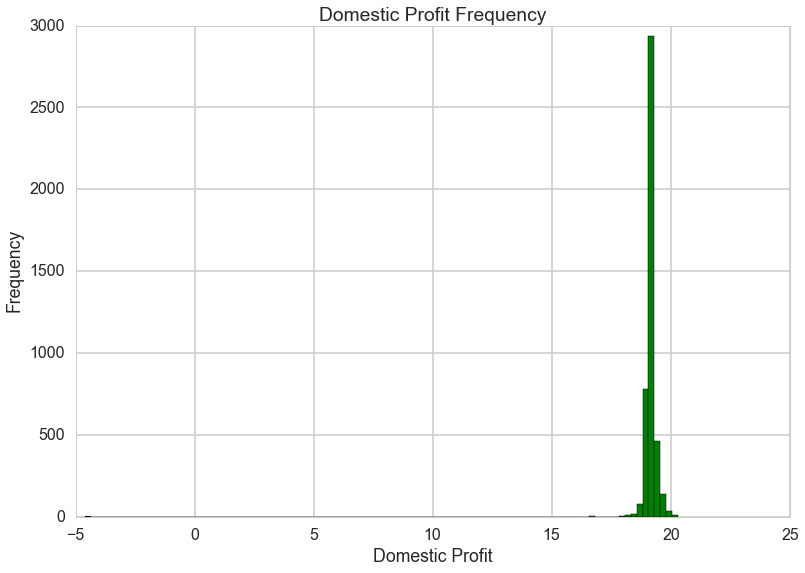

In [124]:
b = np.abs(movieframe["dom_profits"].min()) + .01
movieframe["dom_profit_transform"] = movieframe['dom_profits'].apply(lambda x : np.log(x + b))

plt.hist(movieframe["dom_profit_transform"], bins = 100, color = "g")
plt.xlabel("Domestic Profit")
plt.ylabel("Frequency")
plt.title("Domestic Profit Frequency")

In [226]:
def movie_details(title):
    new_title = title.replace(" ", "+")
    url = "http://api.rottentomatoes.com/api/public/v1.0/movies.json?apikey=dagqdghwaq3e3mxyrp7kmmj5&q=%s&page_limit=1" % new_title
    res = requests.get(url)
    time.sleep(.2)
    js = simplejson.loads(res.content)
    if js["movies"] != []:
        for movie in js["movies"]:
            ratings = movie["ratings"]
            dates = movie["release_dates"]
            critic_score = ratings["critics_score"]
            aud_score = ratings["audience_score"]
            if "theater" not in dates:
                date = "NA"
            else:
                date = dates["theater"]
        return critic_score, aud_score, date
    else:
        return None, None, None
    

In [227]:
movies = movieframe.index
movieframe["critic_rating"] = 0
movieframe["aud_rating"] = 0
movieframe["release_date"] = ""

for movie in movies:
    crit, aud, date = movie_details(movie)
    movieframe.loc[movieframe.index==movie, "critic_rating"] = crit
    movieframe.loc[movieframe.index==movie, "aud_rating"] = aud
    movieframe.loc[movieframe.index==movie, "release_date"] = date
    
movieframe.head()

,budget_rank,budget,domestic_gross,worldwide_gross,dom_profits,total_profits,budget_quart,profit_transform,dom_profit_transform,rating,critic_rating,aud_rating,release_date
Avatar,1,425000000,760507625,2783918982,335507625,2358918982,143.581086,21.627229,20.102344,68,83,82,2009-12-18
Pirates of the Caribbean: At World's End,2,300000000,309420425,963420425,9420425,663420425,131.607401,20.466915,19.169082,7,45,72,2007-05-25
Spectre,3,300000000,178416219,751916219,-121583781,451916219,131.607401,20.147664,18.201996,57,64,66,2015-11-06
The Dark Knight Rises,4,275000000,448139099,1084439099,173139099,809439099,128.775479,20.639764,19.742651,81,87,90,2012-07-20
The Lone Ranger,5,275000000,89289910,259989910,-185710090,-15010090,128.775479,18.374010,16.602448,44,31,51,2013-07-03


In [231]:
movieframe.to_csv("movieframe.csv", encoding='utf-8')

AttributeError: max must be larger than min in range parameter.

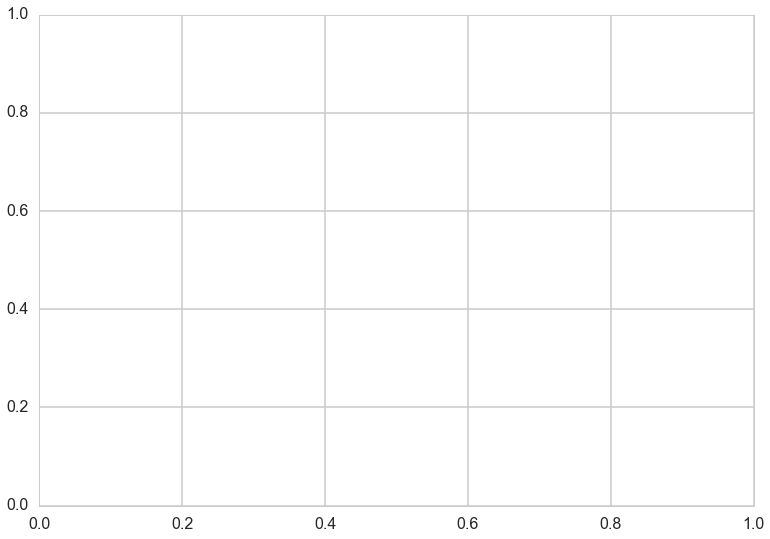

In [233]:
plt.hist(movieframe["critic_rating"], bins = 100, color = "g")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating Frequency")

In [126]:
ols_model = ols("total_profits ~ rating + budget", movieframe).fit()
ols_model
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_profits   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1102.
Date:                Fri, 04 Dec 2015   Prob (F-statistic):               0.00
Time:                        00:16:43   Log-Likelihood:                -89267.
No. Observations:                4471   AIC:                         1.785e+05
Df Residuals:                    4468   BIC:                         1.786e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -4.194e+06    3.7e+06     -1.132      0.258     -1.15e+07  3.07e+06
rating     -8502.4600   5.83e+04     -0.146      0.884     -1.23e+05  1.06e+05
budget         2.0037      0.043     46.935      0.000         1.920     2.087
==============================================================================
Omnibus:                     3530.246   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168301.718
Skew:                           3.369   Prob(JB):                         0.00
Kurtosis:                      32.292   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

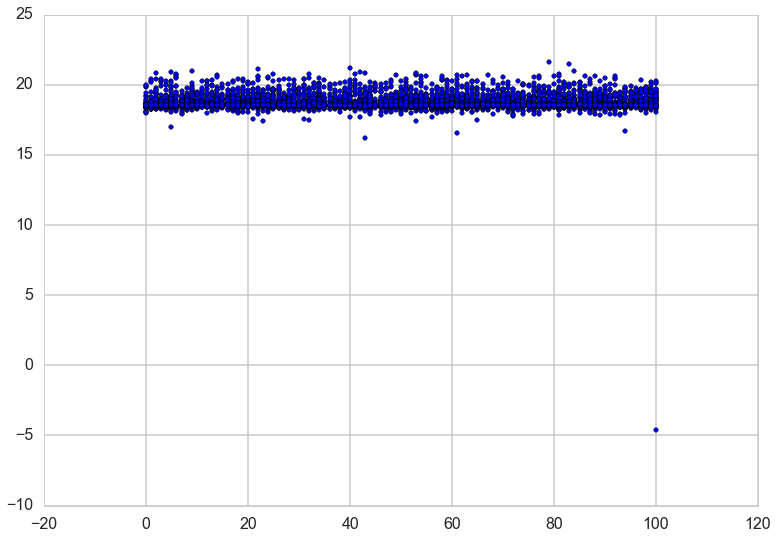

In [133]:
plt.scatter(movieframe["rating"], movieframe["profit_transform"])

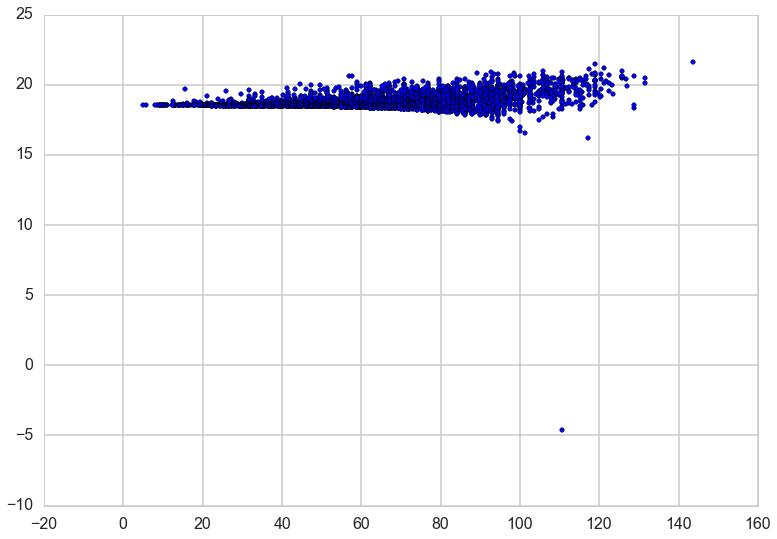

In [132]:
plt.scatter(movieframe["budget_quart"], movieframe["profit_transform"])